# Démonstation : CNN execution via Saimple API


Ce didacticiel illustre l'utilisation de l'API **Saimple**.
Actuellement l'API est stable sur la version v1(deprecated) et v2.

**Saimple API** permet d'accéder à différentes ressources telles que :
+ les **évaluations** `/api/{version}/evaluations/` et leurs résulats:
    + dominance `/api/{version}/evaluations/{id_eval}/dominance`
    + relevance `/api/{version}/evaluations/{id_eval}/relevance`
+ les **images** (inputs) `/api/{version}/evaluations/inputs`
+ les **modèles** (models) `/api/{version}/evaluations/models`
+ les **informations utilitaires** :
    + status `/api/{version}/status`
    + versions `/api/{version}/versions`
    + licence `/api/{version}/licence`

__Requirements__ :
+ saimple_api, utils

#### **Installation de l'environnement conda**

* Créer l'environnement conda à partir du fichier yaml:

> `$ conda env create -f demo_api_saimple.yml`

> `$ conda activate demo_api_saimple`

* Installer le kernel pour l'execution:

> `$ ipython kernel install --user --name=demo_api_saimple`


### 📁 Importation

In [11]:
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import Image
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

sys.path.append('./scripts/')
import saimple_api as api
import utils as utils

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 📁 Initialisation et setup du Path

Choix de la version de l'api : `v2`.

In [12]:
VRS = "v2"

Renseignement de l'URL où l'api va appeler.

In [13]:
URL = "https://app.saimple.com/api" #mettre son URL 

resources = os.path.join('.', 'data')

## 💡 Appel de l'API

Dans la version v2, l'authentification est fait par token.
> Par exemple en utilisant l'utilisateur `user` et mot de passe `mdp`.

Cependant dans la version v1 il n'est pas nécessaire de renseigner une authentification.

In [14]:
# Create a api object with url & version to use
import saimple_api as api

if(VRS == "v2"):
    api = api.SaimpleAPI(URL, VRS, "user", "mdp")

else:
    api = api.SaimpleAPI(URL, VRS)

On peut récupérer les informations de configuration de l'API en consultant la ressource `versions` à l'aide de :
> `GET /api/{version}/versions`.

In [15]:
api.get_versions()

{'fann': {'build': '2023-08-30 - 11:06',
  'commit': 'a7b49b50f3b18a42e67c87637947af5a59379b0e',
  'tags': '3.8.1',
  'version': '3.8.0'},
 'fann-libAD': {'build': '2023-08-03 - 09:48',
  'commit': '53fb65d1008bf5bd9d2a6391b6f01f2f0d0a4a6a',
  'tags': '4.0.0;4.1.0',
  'version': '4.1.0'},
 'abstari': {'version': '4.1.0', 'additional_info': []}}

# 🖐️ Évaluation du modèle

Pour la démonstration, on prend l'évaluation d'un simple réseau de neurones convolutifs (CNN) qui permet de reconnaître le chiffre entre 0 et 9 representé par un geste de la main dans la langue des signes.

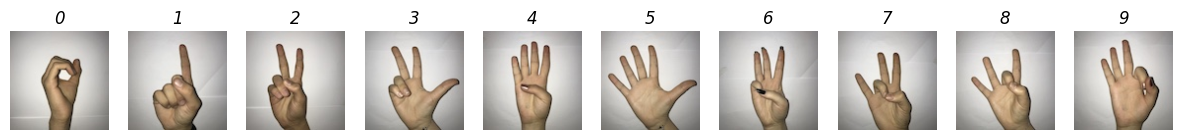

In [43]:
fig, axs = plt.subplots(1,10, figsize=(15,2))
for i in range(0, 10):
    image = Image.open(os.path.join(resources, 'inputs/sign_'+ str(i) +'.jpeg'))
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(str(i), fontstyle='italic')
plt.show()

Pour l'exemple l'image `sign_0.jpeg` est sélectionnée en tant qu'objet de l'évaluation.

![sign_0](./data/inputs/sign_0.jpeg)

In [29]:
# Sign Language
image_path_sign = os.path.join(resources, 'inputs/sign_0.jpeg')
# Save image name, needed for evaluations
image_sign_name  = os.path.basename(image_path_sign)

L'image est postée via l'API à l'aide de :
> `POST /api/{version}/inputs`.

In [44]:
# Post images
# api.post_image(image_path_sign)
sign_input_id = api.post_input(image_path_sign)

Le modèle est posté via l'API à l'aide de : 
> `POST /api/{version}/models`.

In [45]:
model_path_sign = os.path.join(resources, 'models/Sign_language_Digits.onnx')
# Post models & save IDs models
sign_model_id  = api.post_model(model_path_sign)


Successfully uploaded model : Sign_language_Digits.onnx


## 🛠 Configuration de l'évaluation

Pour lancer l'évaluation, une configuration est créée `conv_eval_sign` pour le post.

Elle donne les caractéristiques de l'évaluation, l'image est renseignée en `"input"` et le modèle en `"model"`, postée au préalable. On assigne un nom à l'évaluation `"Eval from API v2"` et éventuellement une description.
On informe le type d'input `"dataType"` et son domaine de définition `"inputDomain"`, principalement elles vont de 0 à 255, cependant elles peuvent aussi être de 0 à 1 lorsqu'elles sont normalisées.

`"EvaluationEngine"` définit le moteur d'évaluation, il existe deux option : difann et fann-c *(par défaut)*.
La perturbation des entrées est défini en `"noise"` avec `"intensity"` à `0.0001` et il existe plusieurs modes `NONE`, `ADDITIVE`, `MULTIPLICATIVE`, `BOKEH` et `GAUSSIAN`.

In [46]:
conf_eval_sign  = {
        "name": "test from NB api v2",
        "dataType": "Image",
        "input": sign_input_id['inputId'],
        "reference": 0,
        "model": sign_model_id['modelId'],
        "description": "Eval from API v2",
        "inputDomain": [
            "0",
            "255"
        ],
        "noise": {
            "intensity": "0.0001",
            "mode": "ADDITIVE"
        },
        "analysisType": "double",
        "channelOrder": "last",
        "normalize":  True,
        "evaluationEngine": "difann"
}

## 🚗 Lancement de l'évaluation

Le POST déclanche automatiquement l'évaluation, à l'aide de :
> `POST /api/{version}/evaluations`.

In [48]:
print((conf_eval_sign))
evalId = api.post_evaluations(conf_eval_sign)
print("Evaluation id: ", evalId)

{'name': 'test from NB api v2', 'dataType': 'Image', 'input': 'ce6eb59c-d578-11ee-a4ba-0242ac190008', 'reference': 0, 'model': 'c9fd5192-7a21-11ee-a52a-0242ac190008', 'description': 'Eval from API v2', 'inputDomain': ['0', '255'], 'noise': {'intensity': '0.0001', 'mode': 'ADDITIVE'}, 'analysisType': 'double', 'channelOrder': 'last', 'normalize': True, 'evaluationEngine': 'difann'}
Evaluation id:  f6ad1936-d578-11ee-812c-0242ac190008


Observons le résumer, pour cela on récupère l'évaluation par un appel GET en renseigant l'id de l'évaluation, à l'aide de :
> `GET /api/{version}/evaluations/{evalId}`.

In [51]:
api.get_evaluations(evalId)

{'workspace_path': '/Workspace/saimplev2',
 'modelId': 'c9fd5192-7a21-11ee-a52a-0242ac190008',
 'inputId': 'ce6eb59c-d578-11ee-a4ba-0242ac190008',
 'status': 'DONE',
 'id': 'f6ad1936-d578-11ee-812c-0242ac190008',
 'creationDate': '2024-02-27T15:03:20.830690',
 'evaluationName': 'agitated_torvalds',
 'postProcessing': True,
 'name': 'test from NB api v2',
 'description': 'Eval from API v2',
 'tags': [],
 'dataType': 'Image',
 'inputDomain': ['0', '255'],
 'noise': {'intensity': '0.0001', 'mode': 'ADDITIVE'},
 'analysisType': 'double',
 'channelOrder': 'last',
 'normalize': True,
 'evaluationEngine': 'difann',
 'endDate': '2024-02-27T15:03:25.142346',
 'duration': '00:00:04',
 'inputName': 'sign_0.jpeg',
 'modelName': 'Sign_language_Digits.onnx'}

### 📊 Dominance

Après l'évaluation la dominance est obtenue, à l'aide de :
> `GET /api/{version}/evaluations/{evalId}/dominance`.

In [54]:
# Waiting for the end of the evaluation
while (api.get_eval_status(evalId) == 'IN_PROGRESS'):
    print("\rPlease wait the end of the evaluation.", end='')
    time.sleep(2)
print('\n')

if (api.get_eval_status(evalId) == "DONE"):
    dominance = api.get_dominance(evalId)['classes']
    df_dominance = pd.DataFrame(dominance)
    print(df_dominance)
elif (api.get_evaluations(evalId)['status'] == "FAILED"):
    print("Evaluation failed.")



   id           min           max     status
0   0  9.982421e-01  9.983800e-01   Dominant
1   1  1.122289e-04  1.214235e-04  Dominated
2   2  4.530083e-07  4.934730e-07  Dominated
3   3  8.870867e-08  9.744926e-08  Dominated
4   4  2.739956e-06  3.025193e-06  Dominated
5   5  2.996683e-08  3.334455e-08  Dominated
6   6  3.496771e-06  3.840809e-06  Dominated
7   7  8.748652e-06  9.502328e-06  Dominated
8   8  1.483908e-03  1.612033e-03  Dominated
9   9  8.175963e-06  8.996457e-06  Dominated


La **dominance** se traduit par un intervalle de probabilité d'appartenance de l'image à une classe d'après la prédiction. 

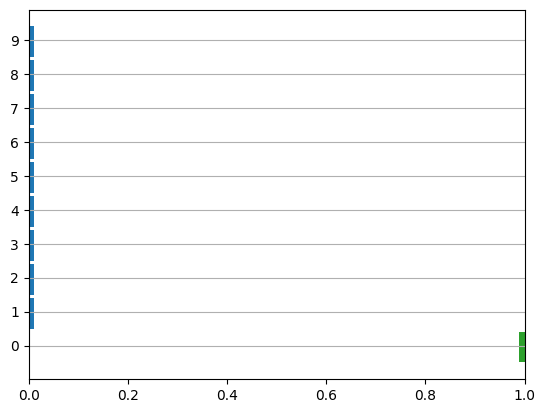

In [55]:
utils.histDominance(df_dominance)

Le graphe ci-dessus montre que la classe 0 est largement dominante face aux autres classes.

### 📈 Relevance

La relevance est obtenue à l'aide de :
> `GET /api/{version}/evaluations/{evalId}/relevance`.

In [56]:
relevance = api.get_relevance(evalId)['data']
df_relevance = pd.DataFrame(relevance[0])
df_relevance

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,"[-1, -1, -1]","[0, 0, 0]","[0, 0, -1]","[0, 0, 0]","[0, -1, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, -1]","[0, -1, -1]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
1,"[0, 0, 0]","[-1, -1, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[-1, 0, -1]","[-1, 0, -1]","[-1, 0, -1]","[0, -1, -1]","[0, -1, -1]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
2,"[-1, 0, 0]","[0, -1, 0]","[0, 0, 0]","[0, 0, -1]","[0, -1, 0]","[-1, 0, 0]","[-1, -1, -1]","[0, -1, -1]","[0, -1, -1]","[-1, -1, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
3,"[-1, 0, 0]","[-1, 0, 0]","[0, 0, 0]","[-1, 0, -1]","[0, 0, -1]","[-1, 0, -1]","[-1, -1, -1]","[-1, -1, -1]","[-1, 0, -1]","[0, -1, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
4,"[-1, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, -1, 0]","[0, -1, 0]","[-1, -1, 0]","[0, 0, -1]","[0, 0, 0]","[-1, -1, 0]","[0, 0, 0]",...,"[0, 0, -1]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
96,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
97,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
98,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"


Soit sous forme visuel. La relevance de la classe dominante. Elle est superposée à l'image de réference.

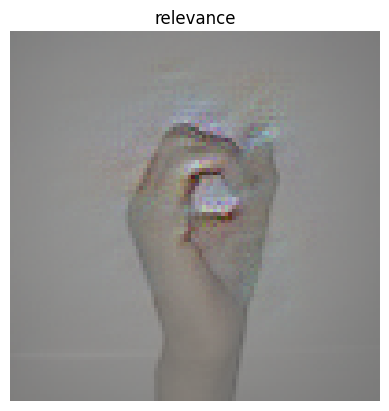

In [57]:
img = np.array(Image.open(os.path.join(image_path_sign)), dtype= float)

utils.showRelevance(df_relevance, img, 0.8)

La relevance pour toutes les classes.

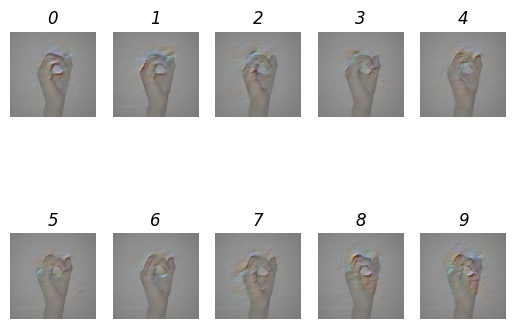

In [17]:
utils.showAllRelevance(relevance, img, 0.8)

À noter que dans cet exemple la relevance est normalisée en local.

## 🗑 Suppression de l'évaluation

Il est possible de supprimer des évaluations pour éviter la surcharge.

Il est possible de suivre l'opération, en affichant la liste des évaluations, à l'aide de :
> `GET /api/{version}/evalutaions` . 

In [18]:
api.get_all_eval()

{'evaluations': [{'workspace_path': '/Workspace/saimplev2',
   'modelId': 'c9fd5192-7a21-11ee-a52a-0242ac190008',
   'inputId': '9d91f0e2-d573-11ee-b36b-0242ac190008',
   'status': 'DONE',
   'id': '9daa3cce-d573-11ee-b36b-0242ac190008',
   'creationDate': '2024-02-27T14:25:04.036347',
   'evaluationName': 'stupefied_hypatia',
   'postProcessing': True,
   'name': 'test from NB api v2',
   'description': 'Eval from API v2',
   'tags': [],
   'dataType': 'Image',
   'inputDomain': ['0', '255'],
   'noise': {'intensity': '0.0001', 'mode': 'ADDITIVE'},
   'analysisType': 'double',
   'channelOrder': 'last',
   'normalize': True,
   'evaluationEngine': 'difann',
   'endDate': '2024-02-27T14:25:07.605429',
   'duration': '00:00:03',
   'inputName': 'sign_0.jpeg',
   'modelName': 'Sign_language_Digits.onnx'},
  {'workspace_path': '/Workspace/saimplev2',
   'modelId': 'c9fd5192-7a21-11ee-a52a-0242ac190008',
   'inputId': '74018f90-d257-11ee-80b0-0242ac190008',
   'status': 'DONE',
   'id': '8

En renseignant  l'**id** de l'évaluation à l'aide de : 
> `DELETE /api/{version}/evaluations/{evalId}`.

In [19]:
del_eval = api.delete_eval(evalId)

Successfully delete evaluation : 9daa3cce-d573-11ee-b36b-0242ac190008


In [20]:
api.get_all_eval()

{'evaluations': [{'workspace_path': '/Workspace/saimplev2',
   'modelId': 'c9fd5192-7a21-11ee-a52a-0242ac190008',
   'inputId': '74018f90-d257-11ee-80b0-0242ac190008',
   'status': 'DONE',
   'id': '8098f7d4-d257-11ee-8539-0242ac190008',
   'creationDate': '2024-02-23T15:26:16.011075',
   'evaluationName': 'brave_wilson',
   'postProcessing': True,
   'name': 'test from NB api v2',
   'description': 'Eval from API v2',
   'tags': [],
   'dataType': 'Image',
   'inputDomain': ['0', '255'],
   'noise': {'intensity': '0.0001', 'mode': 'ADDITIVE'},
   'analysisType': 'double',
   'channelOrder': 'last',
   'normalize': True,
   'evaluationEngine': 'difann',
   'endDate': '2024-02-23T15:26:19.139631',
   'duration': '00:00:03',
   'inputName': 'sign_0.jpeg',
   'modelName': 'Sign_language_Digits.onnx'},
  {'workspace_path': '/Workspace/saimplev2',
   'modelId': 'c9fd5192-7a21-11ee-a52a-0242ac190008',
   'inputId': '5051416c-d158-11ee-8eb2-0242ac190008',
   'status': 'DONE',
   'id': '682119

L'évaluation a bien été supprimée de la liste des évaluations

Ou supprimer toutes les évaluations, à l'aide de :
> `DELETE /api/{version}/evaluations/`.

In [21]:
# api.delete_all_evaluations()

In [22]:
#api.get_all_eval()